# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 쿠폰 코호트 위해 추가한 라이브러리
from matplotlib.gridspec import GridSpec

## 가입기간 병합

- dacon_dataset csv 파일에 가입기간 병합

In [ ]:
all_cluster= pd.read_csv("/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/dacon_dataset.csv")
customer = pd.read_csv('/content/drive/MyDrive/kdt-data-33/DS_DE_33/pjt-1/dacon-raw-data/Customer_info.csv')
# customer 테이블에서 가입기간 추출
customer_period = customer.loc[:, ['고객ID', '가입기간']]
# all_cluster 테이블에 가입기간 병합
all_cluster = pd.merge(all_cluster, customer_period, on='고객ID', how='left')

## 컬럼 생성 및 삭제

In [ ]:
all_cluster['할인금액'] = all_cluster['구매가격'] - all_cluster['monetary']
all_cluster

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,...,할인율,cluster_number,구매가격,부가세,소비자부담가격,쿠폰사용라벨링,monetary,쿠폰 미적용 비용,가입기간,할인금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,2019-01,...,10.0,1,153.71,15.3710,175.5810,1,138.339,153.71,12,15.371
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,2019-01,...,10.0,1,153.71,15.3710,175.5810,1,138.339,153.71,12,15.371
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,2019-01,...,10.0,1,2.05,0.2050,8.7550,1,1.845,2.05,12,0.205
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,2019-01,...,10.0,1,87.65,15.7770,109.9270,0,87.650,87.65,12,0.000
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,2019-01,...,10.0,1,16.50,2.9700,25.9700,1,14.850,16.50,12,1.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,2019-12,...,30.0,2,121.30,12.1300,139.9300,0,121.300,121.30,45,0.000
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,2019-12,...,30.0,2,48.92,8.8056,64.2256,1,34.244,48.92,45,14.676
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,2019-12,...,30.0,2,151.88,15.1880,173.5680,1,106.316,151.88,45,45.564
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,2019-12,...,30.0,2,402.60,40.2600,449.3600,0,402.600,402.60,7,0.000


## 테이블 분리

- 클러스터 분리

In [ ]:
cluster_0 = all_cluster.loc[all_cluster['cluster_number'] == 0].reset_index().drop('index', axis=1)
cluster_1 = all_cluster.loc[all_cluster['cluster_number'] == 1].reset_index().drop('index', axis=1)
cluster_2 = all_cluster.loc[all_cluster['cluster_number'] == 2].reset_index().drop('index', axis=1)
cluster_3 = all_cluster.loc[all_cluster['cluster_number'] == 3].reset_index().drop('index', axis=1)

- 지역 분리

In [ ]:
Chicago_all = all_cluster.loc[all_cluster["고객지역"] == "Chicago"]
California_all = all_cluster.loc[all_cluster["고객지역"] == "California"]
NewJersey_all = all_cluster.loc[all_cluster["고객지역"] == "New Jersey"]
NewYork_all = all_cluster.loc[all_cluster["고객지역"] == "New York"]
WashingtonDC_all = all_cluster.loc[all_cluster["고객지역"] == "Washington DC"]

# 지역별 쿠폰 사용 현황

- 시장 규모는 시카고>캘리>뉴욕>뉴저지>워싱턴DC

## 개요

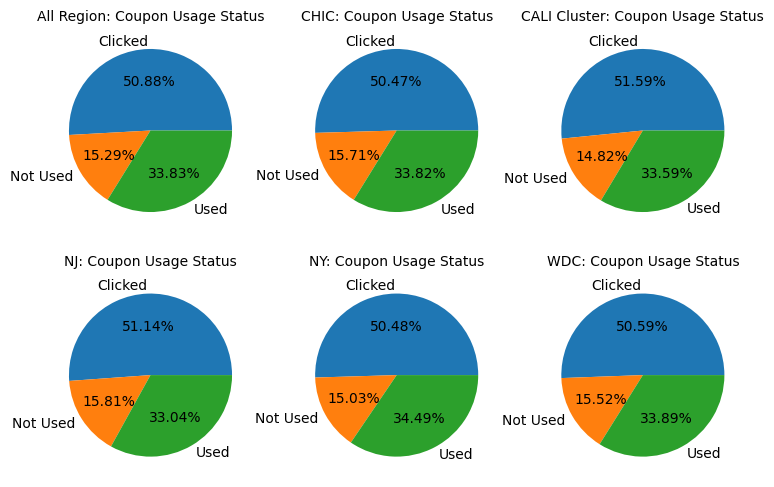

In [ ]:
# 라벨 리스트 생성
xlabel = ['Clicked', 'Not Used', 'Used']
# 데이터 생성
all_pie = all_cluster.groupby('쿠폰상태')['거래ID'].count()
chic_pie = Chicago_all.groupby('쿠폰상태')['거래ID'].count()
cali_pie = California_all.groupby('쿠폰상태')['거래ID'].count()
nj_pie = NewJersey_all.groupby('쿠폰상태')['거래ID'].count()
ny_pie = NewYork_all.groupby('쿠폰상태')['거래ID'].count()
wdc_pie = WashingtonDC_all.groupby('쿠폰상태')['거래ID'].count()

# 그리드 스펙 설정
gridspec = GridSpec(3, 3)
# 이미지 사이즈 설정
fig = plt.figure(figsize=(9, 9))
# 크기에 따라 상이한 서브플롯 생성
ax1 = fig.add_subplot(gridspec[0, 0])
ax2 = fig.add_subplot(gridspec[0, 1])
ax3 = fig.add_subplot(gridspec[0, 2])
ax4 = fig.add_subplot(gridspec[1, 0])
ax5 = fig.add_subplot(gridspec[1, 1])
ax6 = fig.add_subplot(gridspec[1, 2])
# 파이 그래프 생성
ax1.pie(all_pie, labels=xlabel, autopct='%.2f%%')
ax1.set_title('All Region: Coupon Usage Status', fontsize=10)

ax2.pie(chic_pie, labels=xlabel, autopct='%.2f%%')
ax2.set_title('CHIC: Coupon Usage Status', fontsize=10)

ax3.pie(cali_pie, labels=xlabel, autopct='%.2f%%')
ax3.set_title('CALI Cluster: Coupon Usage Status', fontsize=10)

ax4.pie(nj_pie, labels=xlabel, autopct='%.2f%%')
ax4.set_title('NJ: Coupon Usage Status', fontsize=10)

ax5.pie(ny_pie, labels=xlabel, autopct='%.2f%%')
ax5.set_title('NY: Coupon Usage Status', fontsize=10)

ax6.pie(wdc_pie, labels=xlabel, autopct='%.2f%%')
ax6.set_title('WDC: Coupon Usage Status', fontsize=10)


plt.show()


- 쿠폰의 클릭/사용/미사용 비율은 전지역 유사한 양상을 보인다.
- 그렇다면 왜 고객들은 쿠폰을 클릭만 할까?
- 쿠폰의 사용 유무가 재구매와 연관이 있을까?
- 쿠폰을 클릭만 한 사람들이 쿠폰을 사용한다면 리텐션(유지율)이 올라갈까?

In [ ]:
all_cluster.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,기준연월,...,할인율,cluster_number,구매가격,부가세,소비자부담가격,쿠폰사용라벨링,monetary,쿠폰 미적용 비용,가입기간,할인금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,2019-01,...,10.0,1,153.71,15.371,175.581,1,138.339,153.71,12,15.371
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,2019-01,...,10.0,1,153.71,15.371,175.581,1,138.339,153.71,12,15.371
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,2019-01,...,10.0,1,2.05,0.205,8.755,1,1.845,2.05,12,0.205
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,2019-01,...,10.0,1,87.65,15.777,109.927,0,87.650,87.65,12,0.000
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,2019-01,...,10.0,1,16.50,2.970,25.970,1,14.850,16.50,12,1.650


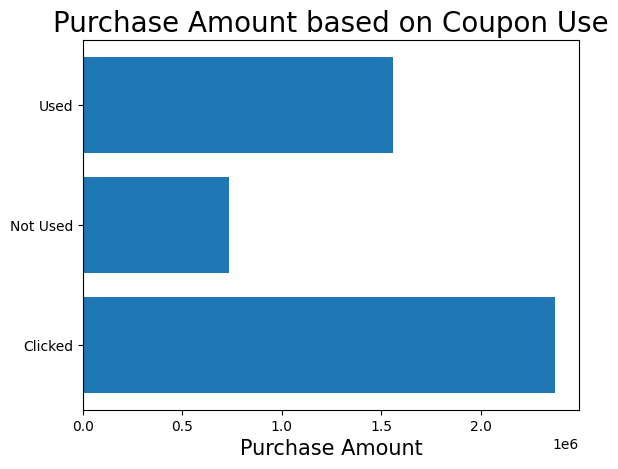

,구매가격
쿠폰상태,
Clicked,2377266.65
Not Used,732709.87
Used,1560818.10


In [ ]:
all_coupon_price = all_cluster.groupby('쿠폰상태')['구매가격'].sum().to_frame()
all_coupon_price
plt.barh(['Clicked', 'Not Used', 'Used'], all_coupon_price['구매가격'])
plt.xlabel('Purchase Amount', fontsize=15)
plt.title('Purchase Amount based on Coupon Use', fontsize=20)
plt.show()
all_coupon_price

## 전지역

전지역에서 쿠폰을 사용한 사람들의 리텐션 코호트 분석

In [ ]:
# 전지역 전고객 쿠폰 사용
all_used = all_cluster[all_cluster['쿠폰상태']=='Used']
# datetime 변환
all_used['거래날짜'] = pd.to_datetime(all_used['거래날짜'])
# 첫 구매 월
all_first_purchase = all_used.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
all_first_purchase.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
all_first_purchase['첫구매월'] = pd.to_datetime(all_first_purchase['첫구매월']).dt.month
# 병합
all_used = pd.merge(all_used, all_first_purchase, on='고객ID')
# 첫 구매 월과 구매 월의 차이
all_used['월차이'] = all_used['거래날짜'].dt.month - all_used['첫구매월']
# 구매횟수 계산
all_cohort = all_used.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# all_cohort['월차이'] = all_cohort['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
all_cohort_pivot = all_cohort.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (all_cohort_size=첫구매월에 따른 고객ID)
all_cohort_size = all_cohort_pivot.iloc[:,0]
all_retention_matrix = all_cohort_pivot.divide(all_cohort_size, axis=0)

전지역에서 쿠폰을 클릭만 했던 사람들의 리텐션 코호트 분석

In [ ]:
# 전지역 전고객 쿠폰 클릭
all_clicked = all_cluster[all_cluster['쿠폰상태']=='Clicked']
# datetime 변환
all_clicked['거래날짜'] = pd.to_datetime(all_clicked['거래날짜'])
# 첫 구매 월
all_first_purchase_ck = all_clicked.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
all_first_purchase_ck.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
all_first_purchase_ck['첫구매월'] = pd.to_datetime(all_first_purchase_ck['첫구매월']).dt.month
# 병합
all_clicked = pd.merge(all_clicked, all_first_purchase_ck, on='고객ID')
# 첫 구매 월과 구매 월의 차이
all_clicked['월차이'] = all_clicked['거래날짜'].dt.month - all_clicked['첫구매월']
# 구매횟수 계산
all_cohort_ck = all_clicked.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# all_cohort_ck['월차이'] = all_cohort_ck['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
all_cohort_ck_pivot = all_cohort_ck.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (all_cohort_ck_size=첫구매월에 따른 고객ID)
all_cohort_ck_size = all_cohort_ck_pivot.iloc[:,0]
all_retention_ck_matrix = all_cohort_ck_pivot.divide(all_cohort_ck_size, axis=0)

시각화

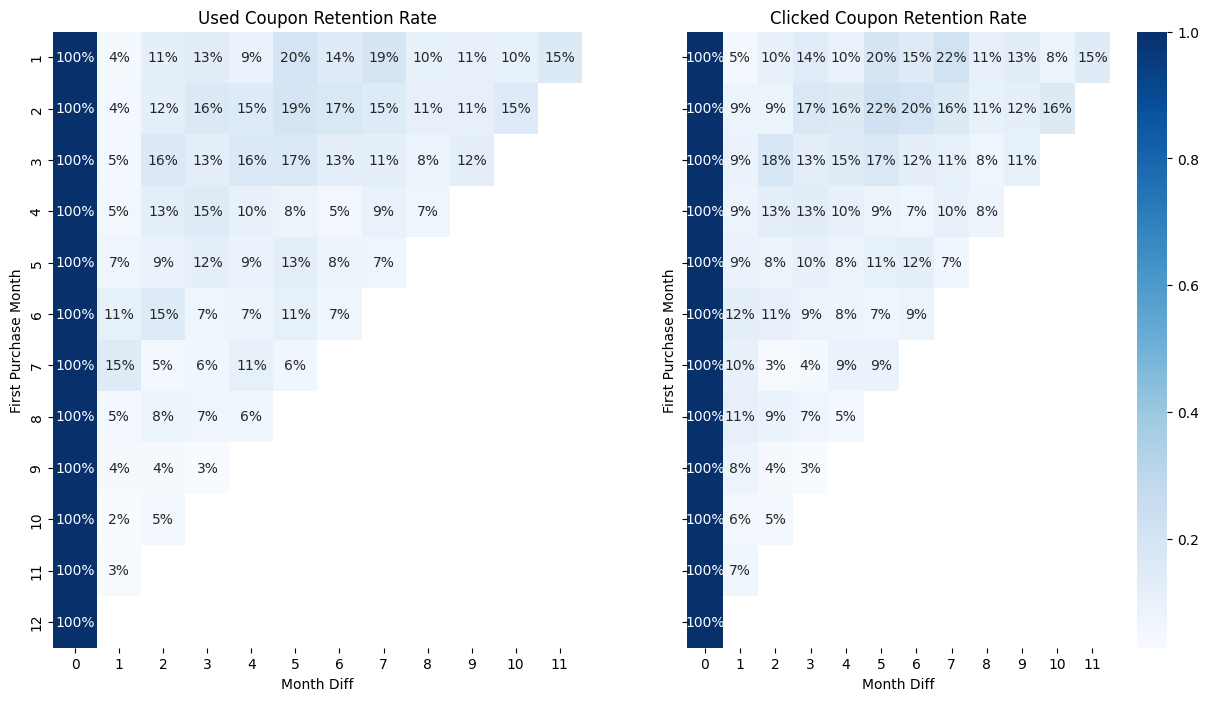

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.set_size_inches((15, 8))
g1 = sns.heatmap(all_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
g1.set_title('Used Coupon Retention Rate')
g1.set_xlabel('Month Diff')
g1.set_ylabel('First Purchase Month')
g2 = sns.heatmap(all_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
g2.set_title('Clicked Coupon Retention Rate')
g2.set_xlabel('Month Diff')
g2.set_ylabel('First Purchase Month')
plt.show()
# 시각화
# plt.figure(figsize=(12, 8))
# plt.title('Cohort Analysis - Coupon Retention Rate', fontsize=20)
# sns.heatmap(data=all_retention_matrix, annot=True, fmt='.0%', cbar=False)
# plt.xlabel('Month Difference', fontsize=15)
# plt.ylabel('First Purchase Month', fontsize=15)
# plt.show()

**[Used Coupon]**
- 7월을 기점으로 쿠폰 사용 유지율이 감소하기 시작
- 쿠폰 유지율은 1-3월 첫 구매자의 경우 가장 활발 => 충성 고객일 가능성 큼

**[Not-Used Coupon]**
- 6월을 기점으로 쿠폰 미사용율이 감소하기 시작
- 대체적으로 쿠폰 사용에 비해 미사용의 리텐션 비율이 작다.

## 시카고

- 지역마다 따로 본다면, 쿠폰 사용과 클릭 양상의 차이가 있을까?

시카고에서 쿠폰을 사용한 사람들의 리텐션 코호트 분석

In [ ]:
# 시카고 쿠폰 사용
chic_used = Chicago_all[Chicago_all['쿠폰상태']=='Used']
# datetime 변환
chic_used['거래날짜'] = pd.to_datetime(chic_used['거래날짜'])
# 첫 구매 월
chic_first_purchase = chic_used.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
chic_first_purchase.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
chic_first_purchase['첫구매월'] = pd.to_datetime(chic_first_purchase['첫구매월']).dt.month
# 병합
chic_used = pd.merge(chic_used, chic_first_purchase, on='고객ID')
# 첫 구매 월과 구매 월의 차이
chic_used['월차이'] = chic_used['거래날짜'].dt.month - chic_used['첫구매월']
# 구매횟수 계산
chic_cohort = chic_used.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# 첫 구매 월은 행으로, 월 차이는 열로
chic_cohort_pivot = chic_cohort.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율
chic_cohort_size = chic_cohort_pivot.iloc[:,0]
chic_retention_matrix = chic_cohort_pivot.divide(chic_cohort_size, axis=0)

시카고에서 쿠폰을 클릭만 한 사람들의 리텐션 코호트 분석

In [ ]:
# 시카고 쿠폰 클릭
chic_clicked = Chicago_all[Chicago_all['쿠폰상태']=='Clicked']
# datetime 변환
chic_clicked['거래날짜'] = pd.to_datetime(chic_clicked['거래날짜'])
# 첫 구매 월
chic_first_purchase_ck = chic_clicked.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
chic_first_purchase_ck.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
chic_first_purchase_ck['첫구매월'] = pd.to_datetime(chic_first_purchase_ck['첫구매월']).dt.month
# 병합
chic_clicked = pd.merge(chic_clicked, chic_first_purchase_ck, on='고객ID')
# 첫 구매 월과 구매 월의 차이
chic_clicked['월차이'] = chic_clicked['거래날짜'].dt.month - chic_clicked['첫구매월']
# 구매횟수 계산
chic_cohort_ck = chic_clicked.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# chic_cohort_ck['월차이'] = chic_cohort_ck['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
chic_cohort_ck_pivot = chic_cohort_ck.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (chic_cohort_ck_size=첫구매월에 따른 고객ID)
chic_cohort_ck_size = chic_cohort_ck_pivot.iloc[:,0]
chic_retention_ck_matrix = chic_cohort_ck_pivot.divide(chic_cohort_ck_size, axis=0)

시각화

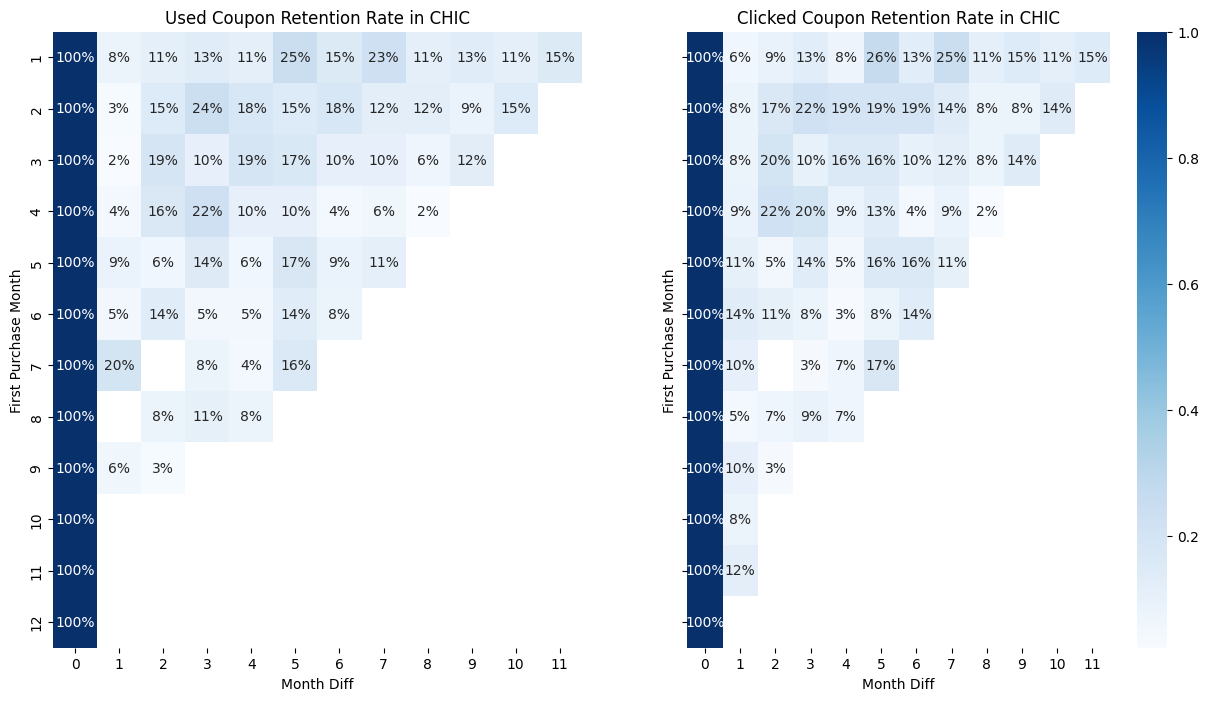

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.set_size_inches((15, 8))
g1 = sns.heatmap(chic_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
g1.set_title('Used Coupon Retention Rate in CHIC')
g1.set_xlabel('Month Diff')
g1.set_ylabel('First Purchase Month')
g2 = sns.heatmap(chic_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
g2.set_title('Clicked Coupon Retention Rate in CHIC')
g2.set_xlabel('Month Diff')
g2.set_ylabel('First Purchase Month')
plt.show()

- 11월에 쿠폰을 사용하지 않고도 제품을 구매한 내역이 있다.

## 캘리포니아

In [ ]:
# 캘리포니아 쿠폰 사용
cali_used = California_all[California_all['쿠폰상태']=='Used']
# datetime 변환
cali_used['거래날짜'] = pd.to_datetime(cali_used['거래날짜'])
# 첫 구매 월
cali_first_purchase = cali_used.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
cali_first_purchase.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
cali_first_purchase['첫구매월'] = pd.to_datetime(cali_first_purchase['첫구매월']).dt.month
# 병합
cali_used = pd.merge(cali_used, cali_first_purchase, on='고객ID')
# 첫 구매 월과 구매 월의 차이
cali_used['월차이'] = cali_used['거래날짜'].dt.month - cali_used['첫구매월']
# 구매횟수 계산
cali_cohort = cali_used.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# 첫 구매 월은 행으로, 월 차이는 열로
cali_cohort_pivot = cali_cohort.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율
cali_cohort_size = cali_cohort_pivot.iloc[:,0]
cali_retention_matrix = cali_cohort_pivot.divide(cali_cohort_size, axis=0)

In [ ]:
# 캘리포니아 쿠폰 클릭
cali_clicked = California_all[California_all['쿠폰상태']=='Clicked']
# datetime 변환
cali_clicked['거래날짜'] = pd.to_datetime(cali_clicked['거래날짜'])
# 첫 구매 월
cali_first_purchase_ck = cali_clicked.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
cali_first_purchase_ck.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
cali_first_purchase_ck['첫구매월'] = pd.to_datetime(cali_first_purchase_ck['첫구매월']).dt.month
# 병합
cali_clicked = pd.merge(cali_clicked, cali_first_purchase_ck, on='고객ID')
# 첫 구매 월과 구매 월의 차이
cali_clicked['월차이'] = cali_clicked['거래날짜'].dt.month - cali_clicked['첫구매월']
# 구매횟수 계산
cali_cohort_ck = cali_clicked.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# cali_cohort_ck['월차이'] = cali_cohort_ck['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
cali_cohort_ck_pivot = cali_cohort_ck.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (cali_cohort_ck_size=첫구매월에 따른 고객ID)
cali_cohort_ck_size = cali_cohort_ck_pivot.iloc[:,0]
cali_retention_ck_matrix = cali_cohort_ck_pivot.divide(cali_cohort_ck_size, axis=0)

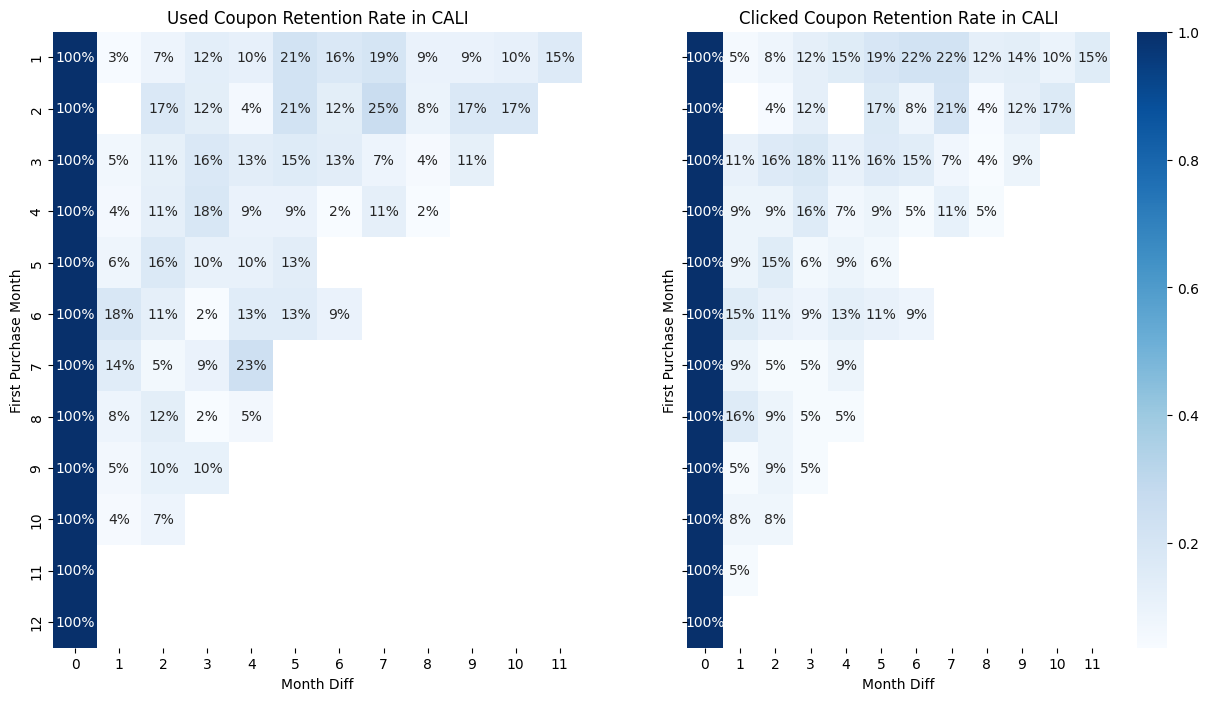

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.set_size_inches((15, 8))
g1 = sns.heatmap(cali_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
g1.set_title('Used Coupon Retention Rate in CALI')
g1.set_xlabel('Month Diff')
g1.set_ylabel('First Purchase Month')
g2 = sns.heatmap(cali_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
g2.set_title('Clicked Coupon Retention Rate in CALI')
g2.set_xlabel('Month Diff')
g2.set_ylabel('First Purchase Month')
plt.show()

- 2월 11월 12월에 처음 쿠폰을 사용했던 사람들은 1개월 이후 재구매가 없었다.

## 뉴저지

In [ ]:
# 뉴저지 쿠폰 사용
nj_used = NewJersey_all[NewJersey_all['쿠폰상태']=='Used']
# datetime 변환
nj_used['거래날짜'] = pd.to_datetime(nj_used['거래날짜'])
# 첫 구매 월
nj_first_purchase = nj_used.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
nj_first_purchase.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
nj_first_purchase['첫구매월'] = pd.to_datetime(nj_first_purchase['첫구매월']).dt.month
# 병합
nj_used = pd.merge(nj_used, nj_first_purchase, on='고객ID')
# 첫 구매 월과 구매 월의 차이
nj_used['월차이'] = nj_used['거래날짜'].dt.month - nj_used['첫구매월']
# 구매횟수 계산
nj_cohort = nj_used.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# 첫 구매 월은 행으로, 월 차이는 열로
nj_cohort_pivot = nj_cohort.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율
nj_cohort_size = nj_cohort_pivot.iloc[:,0]
nj_retention_matrix = nj_cohort_pivot.divide(nj_cohort_size, axis=0)

In [ ]:
# 뉴저지 쿠폰 클릭
nj_clicked = NewJersey_all[NewJersey_all['쿠폰상태']=='Clicked']
# datetime 변환
nj_clicked['거래날짜'] = pd.to_datetime(nj_clicked['거래날짜'])
# 첫 구매 월
nj_first_purchase_ck = nj_clicked.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
nj_first_purchase_ck.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
nj_first_purchase_ck['첫구매월'] = pd.to_datetime(nj_first_purchase_ck['첫구매월']).dt.month
# 병합
nj_clicked = pd.merge(nj_clicked, nj_first_purchase_ck, on='고객ID')
# 첫 구매 월과 구매 월의 차이
nj_clicked['월차이'] = nj_clicked['거래날짜'].dt.month - nj_clicked['첫구매월']
# 구매횟수 계산
nj_cohort_ck = nj_clicked.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# nj_cohort_ck['월차이'] = nj_cohort_ck['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
nj_cohort_ck_pivot = nj_cohort_ck.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (nj_cohort_ck_size=첫구매월에 따른 고객ID)
nj_cohort_ck_size = nj_cohort_ck_pivot.iloc[:,0]
nj_retention_ck_matrix = nj_cohort_ck_pivot.divide(nj_cohort_ck_size, axis=0)

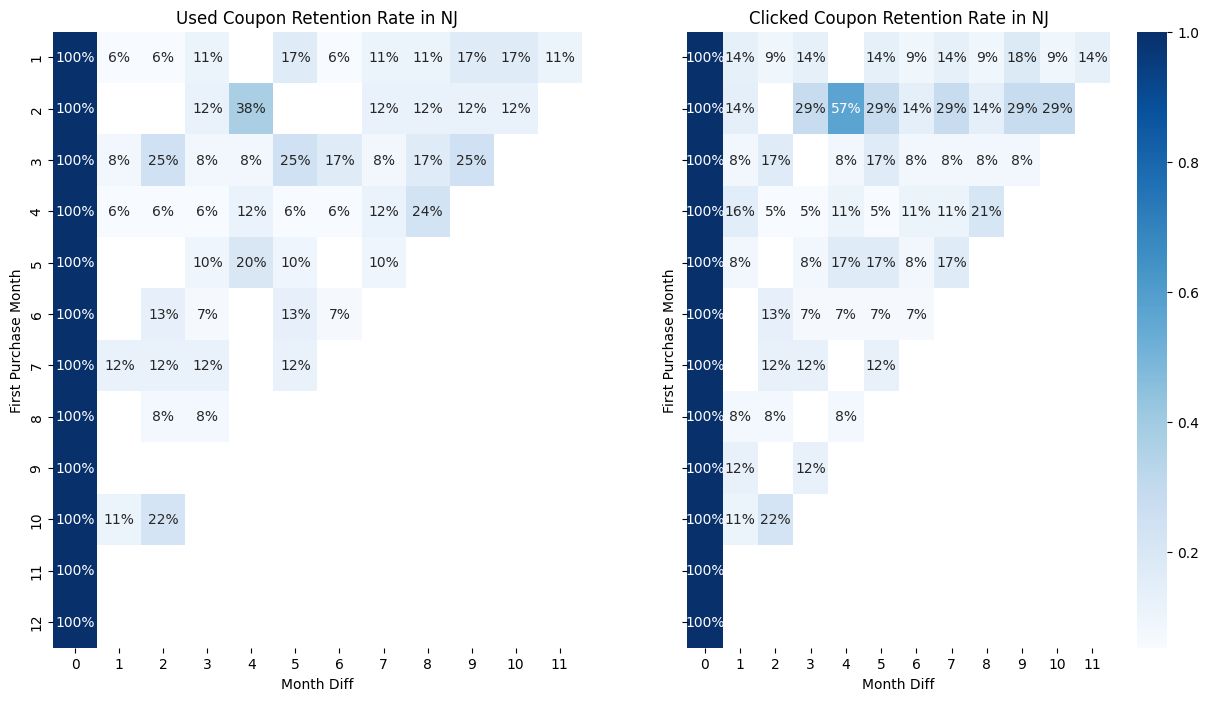

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.set_size_inches((15, 8))
g1 = sns.heatmap(nj_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
g1.set_title('Used Coupon Retention Rate in NJ')
g1.set_xlabel('Month Diff')
g1.set_ylabel('First Purchase Month')
g2 = sns.heatmap(nj_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
g2.set_title('Clicked Coupon Retention Rate in NJ')
g2.set_xlabel('Month Diff')
g2.set_ylabel('First Purchase Month')
plt.show()

- 2개월 이상 쿠폰 사용 유지가 되지 않을 때도 많다.
- 지속적으로 2월에 쿠폰 사용과 클릭 유지율이 높아진다.
- 2월에 쿠폰을 사용 혹은 클릭만 해서 첫 구매한 사람들이 6월에 가장 높은 리텐션을 보인다.
  - 뉴저지에서만의 특징으로, 지역별 프로모션 있었던 것으로 예상

## 뉴욕

In [ ]:
# 뉴욕 쿠폰 사용
ny_used = NewYork_all[NewYork_all['쿠폰상태']=='Used']
# datetime 변환
ny_used['거래날짜'] = pd.to_datetime(ny_used['거래날짜'])
# 첫 구매 월
ny_first_purchase = ny_used.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
ny_first_purchase.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
ny_first_purchase['첫구매월'] = pd.to_datetime(ny_first_purchase['첫구매월']).dt.month
# 병합
ny_used = pd.merge(ny_used, ny_first_purchase, on='고객ID')
# 첫 구매 월과 구매 월의 차이
ny_used['월차이'] = ny_used['거래날짜'].dt.month - ny_used['첫구매월']
# 구매횟수 계산
ny_cohort = ny_used.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# 첫 구매 월은 행으로, 월 차이는 열로
ny_cohort_pivot = ny_cohort.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율
ny_cohort_size = ny_cohort_pivot.iloc[:,0]
ny_retention_matrix = ny_cohort_pivot.divide(ny_cohort_size, axis=0)

In [ ]:
# 뉴욕 쿠폰 클릭
ny_clicked = NewYork_all[NewYork_all['쿠폰상태']=='Clicked']
# datetime 변환
ny_clicked['거래날짜'] = pd.to_datetime(ny_clicked['거래날짜'])
# 첫 구매 월
ny_first_purchase_ck = ny_clicked.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
ny_first_purchase_ck.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
ny_first_purchase_ck['첫구매월'] = pd.to_datetime(ny_first_purchase_ck['첫구매월']).dt.month
# 병합
ny_clicked = pd.merge(ny_clicked, ny_first_purchase_ck, on='고객ID')
# 첫 구매 월과 구매 월의 차이
ny_clicked['월차이'] = ny_clicked['거래날짜'].dt.month - ny_clicked['첫구매월']
# 구매횟수 계산
ny_cohort_ck = ny_clicked.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# ny_cohort_ck['월차이'] = ny_cohort_ck['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
ny_cohort_ck_pivot = ny_cohort_ck.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (ny_cohort_ck_size=첫구매월에 따른 고객ID)
ny_cohort_ck_size = ny_cohort_ck_pivot.iloc[:,0]
ny_retention_ck_matrix = ny_cohort_ck_pivot.divide(ny_cohort_ck_size, axis=0)

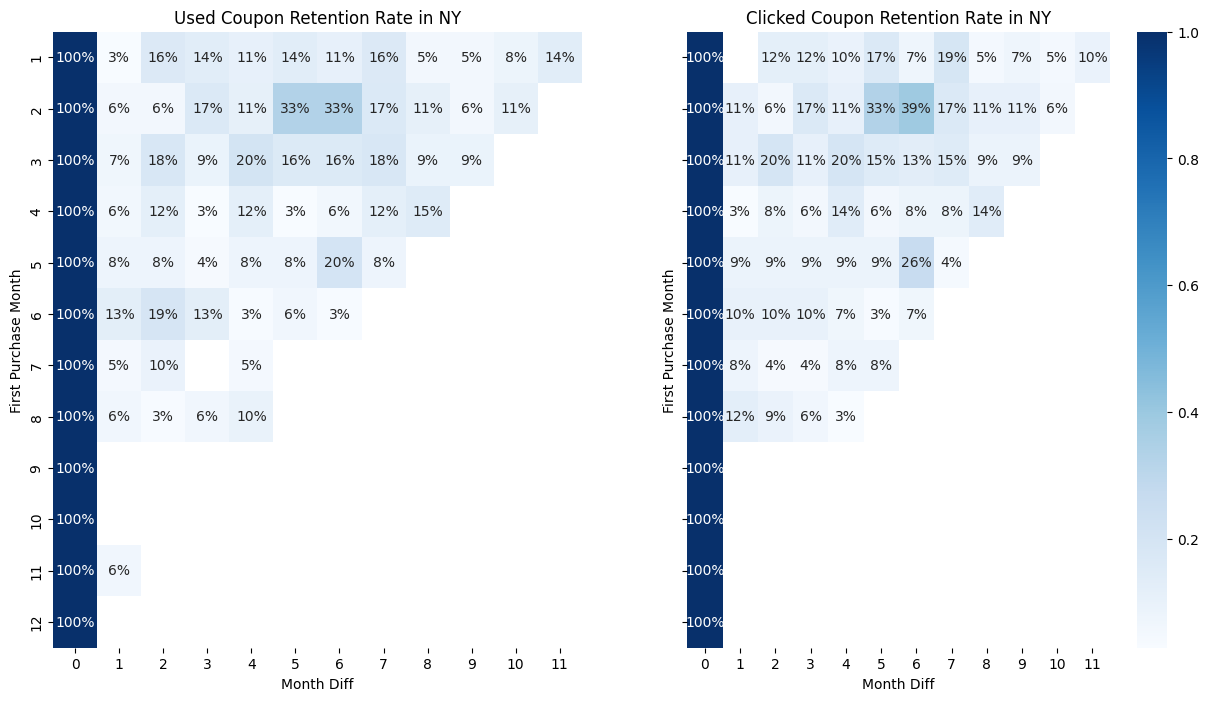

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.set_size_inches((15, 8))
g1 = sns.heatmap(ny_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
g1.set_title('Used Coupon Retention Rate in NY')
g1.set_xlabel('Month Diff')
g1.set_ylabel('First Purchase Month')
g2 = sns.heatmap(ny_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
g2.set_title('Clicked Coupon Retention Rate in NY')
g2.set_xlabel('Month Diff')
g2.set_ylabel('First Purchase Month')
plt.show()

- 9월 10월 12월 첫구매자의 경우 재구매가 없다.
  - 9-12월 첫구매자가 쿠폰을 사용할 수 있는 비율이 컸다면 리텐션이 높았을까?

## 워싱턴DC

In [ ]:
# 워싱턴DC 쿠폰 사용
wdc_used = WashingtonDC_all[WashingtonDC_all['쿠폰상태']=='Used']
# datetime 변환
wdc_used['거래날짜'] = pd.to_datetime(wdc_used['거래날짜'])
# 첫 구매 월
wdc_first_purchase = wdc_used.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
wdc_first_purchase.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
wdc_first_purchase['첫구매월'] = pd.to_datetime(wdc_first_purchase['첫구매월']).dt.month
# 병합
wdc_used = pd.merge(wdc_used, wdc_first_purchase, on='고객ID')
# 첫 구매 월과 구매 월의 차이
wdc_used['월차이'] = wdc_used['거래날짜'].dt.month - wdc_used['첫구매월']
# 구매횟수 계산
wdc_cohort = wdc_used.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# 첫 구매 월은 행으로, 월 차이는 열로
wdc_cohort_pivot = wdc_cohort.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율
wdc_cohort_size = wdc_cohort_pivot.iloc[:,0]
wdc_retention_matrix = wdc_cohort_pivot.divide(wdc_cohort_size, axis=0)

In [ ]:
# 워싱턴DC 쿠폰 클릭
wdc_clicked = WashingtonDC_all[WashingtonDC_all['쿠폰상태']=='Clicked']
# datetime 변환
wdc_clicked['거래날짜'] = pd.to_datetime(wdc_clicked['거래날짜'])
# 첫 구매 월
wdc_first_purchase_ck = wdc_clicked.groupby('고객ID')['거래날짜'].min().reset_index()
# 컬럼명 바꾸기
wdc_first_purchase_ck.columns = ['고객ID', '첫구매월']
# datetime 변환 + 월만 반환
wdc_first_purchase_ck['첫구매월'] = pd.to_datetime(wdc_first_purchase_ck['첫구매월']).dt.month
# 병합
wdc_clicked = pd.merge(wdc_clicked, wdc_first_purchase_ck, on='고객ID')
# 첫 구매 월과 구매 월의 차이
wdc_clicked['월차이'] = wdc_clicked['거래날짜'].dt.month - wdc_clicked['첫구매월']
# 구매횟수 계산
wdc_cohort_ck = wdc_clicked.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# wdc_cohort_ck['월차이'] = wdc_cohort_ck['월차이'] + 1
# 첫 구매 월은 행으로, 월 차이는 열로
wdc_cohort_ck_pivot = wdc_cohort_ck.pivot(
    index='첫구매월',
    columns='월차이',
    values='고객ID'
)
# 첫 구매 이후 월별 재구매율 (wdc_cohort_ck_size=첫구매월에 따른 고객ID)
wdc_cohort_ck_size = wdc_cohort_ck_pivot.iloc[:,0]
wdc_retention_ck_matrix = wdc_cohort_ck_pivot.divide(wdc_cohort_ck_size, axis=0)

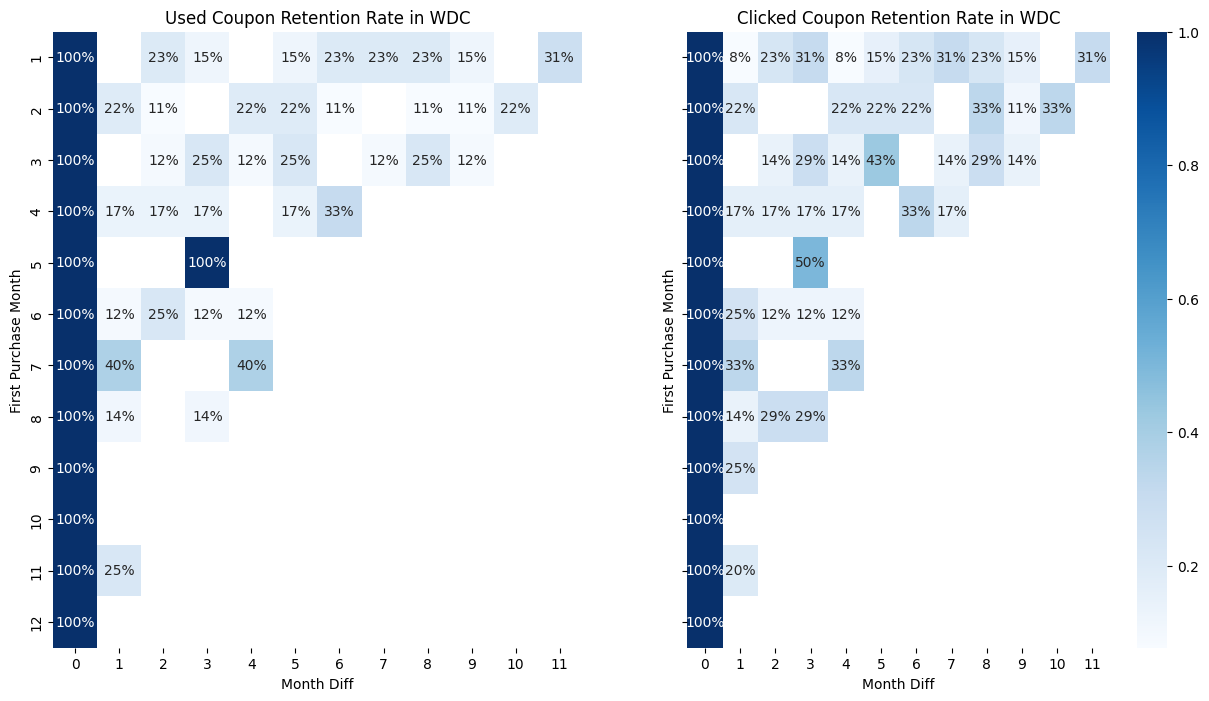

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.set_size_inches((15, 8))
g1 = sns.heatmap(wdc_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
g1.set_title('Used Coupon Retention Rate in WDC')
g1.set_xlabel('Month Diff')
g1.set_ylabel('First Purchase Month')
g2 = sns.heatmap(wdc_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
g2.set_title('Clicked Coupon Retention Rate in WDC')
g2.set_xlabel('Month Diff')
g2.set_ylabel('First Purchase Month')
plt.show()

- 다른 지역에 비해, 평균 리텐션은 높은 편이나 지역 규모가 아주 작은 워싱턴DC
- 1-3월 쿠폰 클릭만한 첫구매자가 다시 쿠폰을 클릭만 한 비중이 높다.
  - 사용이 가능했다면 리텐션이 올라갈까?

# 쿠폰 사용에 따른 재구매 시뮬레이션
- 만약 클릭만 했던 사람들이 쿠폰을 사용했더라면, 실제 쿠폰 사용자들의 리텐션 비율보다 높아질까? \
~고객ID당 재구매율 붙여보려고 했지만.. 실패~

### 가설

**가설1) 할인금액이 클수록 거래횟수가 증가할 것이다.** \
**가설2) 쿠폰을 클릭만 한 그룹이 쿠폰을 사용한다면, 실제 쿠폰 사용자들보다 거래횟수가 증가할 것이다.**
- **적용 그룹**: 쿠폰 상태가 Clicked인 고객
- **키포인트**: 월 차이가 줄어든다 => 첫 구매월과 거래 날짜의 주기가 짧아진다 => 즉 거래횟수가 늘어난다.
- **주요 컬럼**: 쿠폰상태, 거래ID, 할인금액, 구매가격

(상관관계가 높은 feature가 많아서 다중공선성 문제 우려되어, 할인금액 - 구매가격으로 묶음)

## 로우 데이터 생성

- 같은 고객이더라도 같은 거래에서 쿠폰을 사용한 경우도, 사용안하고 클릭만 한 경우도 있어서 고객ID로 그루핑하기 부적합하다고 판단
- 기존에 all_used와 all_clicked 고객 데이터 프레임을 각 쿠폰 상태에 맞춰 라벨링한 컬럼만 생성하고 그대로 concat
- 고객ID는 생각하지 않는 것으로 가정, 쿠폰상태와 지역이 주안점!
- `pd.concat([df1, df2], axis=0).reset_index(drop=True)`

**쿠폰 사용 그룹**

In [ ]:
# 데이터 불러오기
all_used_group = all_used.groupby(['고객ID', '고객지역']).agg({
    '할인금액':[np.sum],
    '거래ID':'nunique',
    '구매가격':[np.sum],
}).reset_index()
# 컬럼명 변경
all_used_group.columns = ['customerID', 'region', 'discnt price', 'transaction', 'price']
all_used_group['coupon status'] = 'Used'
all_used_group


,customerID,region,discnt price,transaction,price,coupon status
0,USER_0000,New York,9.297,1,30.99,Used
1,USER_0001,New York,781.548,18,3074.80,Used
2,USER_0002,California,130.705,4,705.45,Used
3,USER_0003,California,152.217,6,507.39,Used
4,USER_0004,Chicago,206.748,7,689.16,Used
...,...,...,...,...,...,...
1369,USER_1461,Chicago,397.644,3,1325.48,Used
1370,USER_1463,California,11.190,1,111.90,Used
1371,USER_1464,New York,230.312,12,980.96,Used
1372,USER_1465,Chicago,3.563,1,35.63,Used


**쿠폰 클릭(할인 적용) 그룹**

In [ ]:
## 쿠폰 클릭 그룹이 실제 할인을 받았다고 가정하여 테이블 생성

# def coupon_clicked(group):
# 원본 복사
all_clicked_discnt = all_clicked.copy()
# 할인 적용된 금액으로 monetary 수정
all_clicked_discnt['monetary'] = all_clicked_discnt['구매가격'] * (1-(all_clicked_discnt['할인율'] * 0.01))
# 변경된 monetary로 할인금액 컬럼 수정
all_clicked_discnt['할인금액'] = all_clicked_discnt['구매가격'] - all_clicked_discnt['monetary']
# 데이터 분할
all_clicked_discnt_group = all_clicked_discnt.groupby(['고객ID', '고객지역']).agg({
    '할인금액':[np.sum],
    '거래ID':'nunique',
    '구매가격':[np.sum],
}).reset_index()
# 컬럼명 변경
all_clicked_discnt_group.columns = ['customerID', 'region', 'discnt price', 'transaction', 'price']
all_clicked_discnt_group['coupon status'] = 'Clicked'
all_clicked_discnt_group

,customerID,region,discnt price,transaction,price,coupon status
0,USER_0001,New York,1611.315,18,5687.14,Clicked
1,USER_0002,California,165.016,7,723.68,Clicked
2,USER_0003,California,153.918,6,513.06,Clicked
3,USER_0004,Chicago,129.387,8,431.29,Clicked
4,USER_0005,New York,85.976,2,429.88,Clicked
...,...,...,...,...,...,...
1417,USER_1462,California,2.078,2,20.78,Clicked
1418,USER_1463,California,40.446,3,422.05,Clicked
1419,USER_1464,New York,325.241,14,1343.81,Clicked
1420,USER_1465,Chicago,7.932,2,49.94,Clicked


**used와 clicked 데이터프레임 concat**

In [ ]:
all_group_raw = pd.concat([all_used_group, all_clicked_discnt_group], axis=0).reset_index(drop=True).drop('customerID', axis=1 )
all_group_raw

,region,discnt price,transaction,price,coupon status
0,New York,9.297,1,30.99,Used
1,New York,781.548,18,3074.80,Used
2,California,130.705,4,705.45,Used
3,California,152.217,6,507.39,Used
4,Chicago,206.748,7,689.16,Used
...,...,...,...,...,...
2791,California,2.078,2,20.78,Clicked
2792,California,40.446,3,422.05,Clicked
2793,New York,325.241,14,1343.81,Clicked
2794,Chicago,7.932,2,49.94,Clicked


**원-핫 인코딩**

In [ ]:
# 지역 원핫인코딩
region_dic = {'region':['Chicago', 'California', 'New Jersey', 'New York', 'Washington DC']}
region_df = pd.DataFrame(region_dic)
region_ohe = pd.get_dummies(all_group_raw['region'])
region_ohe

,California,Chicago,New Jersey,New York,Washington DC
0,0,0,0,1,0
1,0,0,0,1,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
2791,1,0,0,0,0
2792,1,0,0,0,0
2793,0,0,0,1,0
2794,0,1,0,0,0


In [ ]:
# 쿠폰상태 원핫인코딩
coupon_dic = {'coupon':['Used', 'Clicked']}
coupon_df = pd.DataFrame(coupon_dic)
coupon_ohe = pd.get_dummies(all_group_raw['coupon status'])
coupon_ohe

,Clicked,Used
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2791,1,0
2792,1,0
2793,1,0
2794,1,0


**원핫인코딩 concat**

In [ ]:
all_group_raw = pd.concat([all_group_raw, region_ohe, coupon_ohe], axis=1).drop(['region', 'coupon status'], axis=1)
# .reset_index(drop=True).drop('customerID', axis=1 )
all_group_raw

,discnt price,transaction,price,California,Chicago,New Jersey,New York,Washington DC,Clicked,Used
0,9.297,1,30.99,0,0,0,1,0,0,1
1,781.548,18,3074.80,0,0,0,1,0,0,1
2,130.705,4,705.45,1,0,0,0,0,0,1
3,152.217,6,507.39,1,0,0,0,0,0,1
4,206.748,7,689.16,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2791,2.078,2,20.78,1,0,0,0,0,1,0
2792,40.446,3,422.05,1,0,0,0,0,1,0
2793,325.241,14,1343.81,0,0,0,1,0,1,0
2794,7.932,2,49.94,0,1,0,0,0,1,0


**거래횟수와 할인금액 상관관계 시각화**

In [ ]:
from scipy import stats
import statsmodels.api as sm
# 피어슨 상관계수 확인
stats.pearsonr(all_group_raw['transaction'], all_group_raw['discnt price'])

PearsonRResult(statistic=0.8910775633244752, pvalue=0.0)

Text(0, 0.5, 'Discount Price')

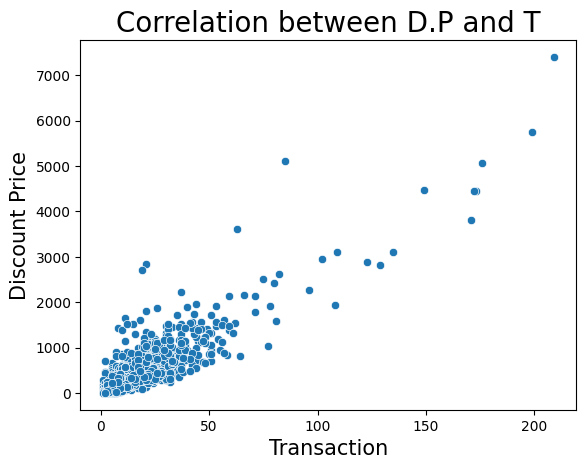

In [ ]:
sns.scatterplot(data=all_group_raw, x='transaction', y='discnt price')
plt.title('Correlation between D.P and T', fontsize=20)
plt.xlabel('Transaction', fontsize=15)
plt.ylabel('Discount Price', fontsize=15)

## A. 전지역

### 처음부터 다시

#### 전지역-쿠폰사용

- 데이터분리 - 정규화 - 모델생성 - 모델 훈련(fit) - 정확도 확인 - 모델 예측 - 검증

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_group_raw.drop('transaction', axis=1),
    all_group_raw['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2236, 9), (560, 9), (2236,), (560,))

In [ ]:
scaler = MinMaxScaler()
X = all_group_raw.drop('transaction', axis=1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)
X_train_scaled.columns = X_test_scaled.columns = ['discnt price',	'price',	'California',	'Chicago',	'New Jersey',	'New York',	'Washington DC',	'Clicked',	'Used']

In [ ]:
# 모델 생성
all_lr_scaled = LinearRegression().fit(X_train_scaled.iloc[:, :2], y_train)

In [ ]:
# 모델 정확도 확인
def model_accuracy(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  # mse & rmse & r^2 확인
  return print((f'MSE: {mse}'), (f'RMSE: {rmse}'), (f'R^2: {r2}'))

In [ ]:
# 전체 데이터 적용 모델 정확도 확인
y_pred = all_lr_scaled.predict(X_test_scaled.iloc[:, :2])
model_accuracy(y_test, y_pred)

MSE: 33.36519069255768 RMSE: 5.776260961258388 R^2: 0.846190777344835


훈련세트와 테스트세트의 정확도도 비교?! \
지역별 정확도를 구하려면 y_test값도 매번 분할해야 해서 전체 정확도만 구했다. \
ex. `y_pred = lr.predict(X_test_scaled[X_test_scaled['Used']==1])` \
y_pred에 따라 y_test도 크기를 맞추기 위해 매번 분할해야 한다.

In [ ]:
# 정확도 확인22
all_lr_scaled.score(X_test_scaled.iloc[:, :2], y_test)

0.846190777344835

In [ ]:
# 평균값 구하기
def X_mean(X_test):
  X_test_mean = X_test.mean()
  X_test_df = pd.DataFrame(X_test)
  data1 = X_test_df.iloc[:,0].mean()
  data2 = X_test_df.iloc[:, 1].mean()
  sample = pd.DataFrame([{'discnt price':data1, 'price':data2}])
  return sample

In [ ]:
# 전체 지역에서 쿠폰 사용만 추출
X_test_all_used = X_test_scaled[X_test_scaled['Used']==1]
X_mean(X_test_all_used)

,discnt price,price
0,0.02837,0.02302


In [ ]:
# 테스트 세트 생성
def test_set(X_test, n):
  # 0에서 0.9까지 독립변수의 몇 퍼센트를 증가시킬지 설정 (10/20/30% 진행)
  array = np.arange(0, 1, 0.1*n)
  # 독립변수별 리스트 생성
  discnt_price_list = []
  price_list = []

  for i in array:
    discnt_price_list.append(X_mean(X_test)['discnt price']*(1+i))
    price_list.append(X_mean(X_test)['price'])

  test_dict = {
      'discnt price' : discnt_price_list,
      'price' : price_list
  }
  # price는 동일하고, discnt price는 10/20/30% 증가하는 DF
  test_set = pd.DataFrame(test_dict)
  return test_set
X_test_all_used

,discnt price,price,California,Chicago,New Jersey,New York,Washington DC,Clicked,Used
1,0.035348,0.030668,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.002241,0.002938,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.094698,0.051258,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.000254,0.000412,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12,0.005769,0.004674,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
553,0.015588,0.008998,1.0,0.0,0.0,0.0,0.0,0.0,1.0
555,0.000246,0.000189,0.0,0.0,1.0,0.0,0.0,0.0,1.0
556,0.031154,0.032316,1.0,0.0,0.0,0.0,0.0,0.0,1.0
557,0.062343,0.043230,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
test_set(X_test_all_used, 1)

,discnt price,price
0,"0 0.02837 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
1,"0 0.031207 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
2,"0 0.034044 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
3,"0 0.036881 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
4,"0 0.039718 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
5,"0 0.042555 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
6,"0 0.045392 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
7,"0 0.048229 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
8,"0 0.051066 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"
9,"0 0.053903 Name: discnt price, dtype: float64","0 0.02302 Name: price, dtype: float64"


In [ ]:
# 거래횟수 예측
all_lr_scaled.predict(test_set(X_test_all_used, 1))

array([8.67080221, 8.76187855, 8.85295489, 8.94403123, 9.03510758,
       9.12618392, 9.21726026, 9.3083366 , 9.39941294, 9.49048928])

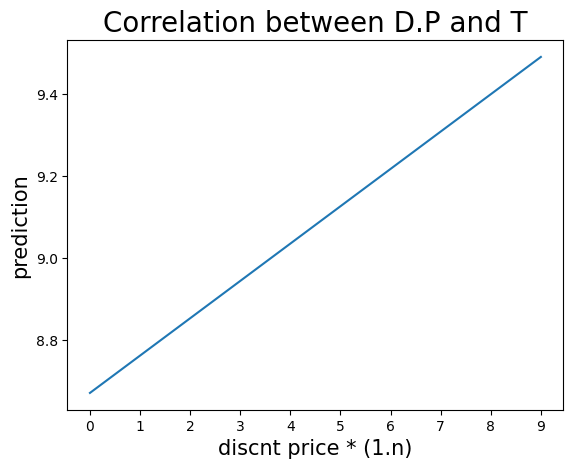

In [ ]:
# tolist() => 값과 컬럼을 리스트로 변환
sns.lineplot(x=np.arange(0, 10, 1), y=all_lr_scaled.predict(test_set(X_test_all_used, 1)).tolist())
# 선형회귀선 시각화
plt.title('Correlation between D.P and T', fontsize=20)
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('discnt price * (1.n)', fontsize=15)
plt.ylabel('prediction', fontsize=15)
plt.show()

In [ ]:
# # 지수표현식 없애기
# pd.options.display.float_format = '{:.6f}'.format
# pct_change() => 행과 행의 차이를 현재값과의 백분율로 출력하는 메서드 => (다음행 - 현재행) / 현재행
pd.DataFrame(all_lr_scaled.predict(test_set(X_test_all_used,1))).pct_change().mean()

0    0.010087
dtype: float64

In [ ]:
# 실제값과 예측값 비교
y_test.mean(), all_lr_scaled.predict(test_set(X_test_all_used,1))[0]

(10.383928571428571, 8.670802208893583)

In [ ]:
all_poly = PolynomialFeatures(degree=2, include_bias=False)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train_scaled.iloc[:,:2])
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test_scaled.iloc[:, :2])
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((2236, 5), (2236, 9), (560, 5), (560, 9))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행
all_poly_lr = all_lr_scaled.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([ 1.63016848, 11.11225906,  9.9839078 ])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 33.572783159274046 RMSE: 5.794202547311756 R^2: 0.8452338028671847


In [ ]:
# 평가 지표 계산

test_mse = mean_squared_error(y_test, y_test_pred)

test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력

print("Test MSE:", test_mse)

print("Test R^2 Score:", test_r2)

Test MSE: 33.572783159274046
Test R^2 Score: 0.8452338028671847


In [ ]:
all_poly_lr_2 = LinearRegression()
all_poly_lr_2.fit(X_poly, y_train)
y_test_pred_2 = all_poly_lr_2.predict(X_poly_test)
model_accuracy(y_test, y_test_pred_2)

MSE: 33.572783159274046 RMSE: 5.794202547311756 R^2: 0.8452338028671847


#### 전지역-쿠폰클릭

In [ ]:
# 전체 지역에서 쿠폰 클릭만 추출
X_test_all_clicked = X_test_scaled[X_test_scaled['Clicked']==1]
X_mean(X_test_all_clicked)

,discnt price,price
0,0.047856,0.039422


In [ ]:
# 테스트 세트
test_set(X_test_all_clicked, 1)

,discnt price,price
0,"0 0.047856 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
1,"0 0.052642 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
2,"0 0.057428 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
3,"0 0.062213 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
4,"0 0.066999 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
5,"0 0.071785 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
6,"0 0.07657 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
7,"0 0.081356 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
8,"0 0.086141 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"
9,"0 0.090927 Name: discnt price, dtype: float64","0 0.039422 Name: price, dtype: float64"


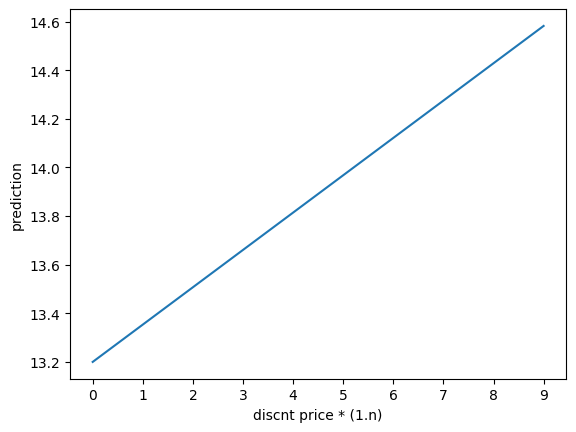

In [ ]:
# 선형회귀선 시각화
sns.lineplot(x=np.arange(0, 10, 1), y=all_lr_scaled.predict(test_set(X_test_all_clicked, 1)).tolist())
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('discnt price * (1.n)')
plt.ylabel('prediction')
plt.show()

In [ ]:
pd.DataFrame(all_lr_scaled.predict(test_set(X_test_all_clicked,1))).pct_change().mean()

0    0.011131
dtype: float64

In [ ]:
y_test.mean(), all_lr_scaled.predict(test_set(X_test_all_clicked,1))[0]

(10.383928571428571, 13.199355115864378)

#### 비교

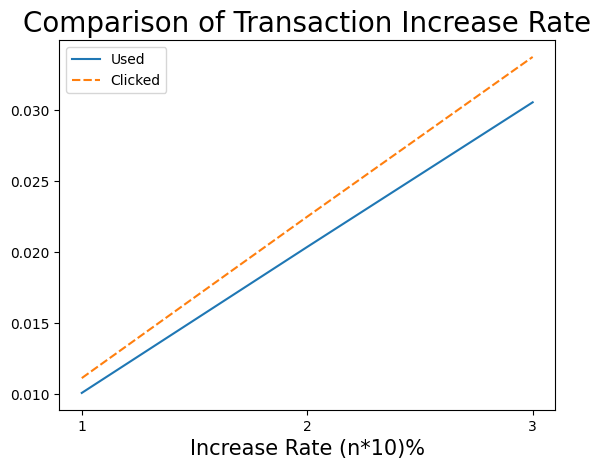

In [ ]:
list1 = []
list2 = []
for num in range(1, 4):
  data1 = pd.DataFrame(all_lr_scaled.predict(test_set(X_test_all_used, num))).pct_change().mean()[0]
  data2 = pd.DataFrame(all_lr_scaled.predict(test_set(X_test_all_clicked, num))).pct_change().mean()[0]
  list1.append(data1)
  list2.append(data2)
df = pd.DataFrame({'Used':list1, 'Clicked':list2}, index=(i for i in range(1, 4)))
sns.lineplot(df)
plt.title('Comparison of Transaction Increase Rate', fontsize=20)
plt.xlabel('Increase Rate (n*10)%', fontsize=15)
plt.xticks([1,2,3])
plt.show()

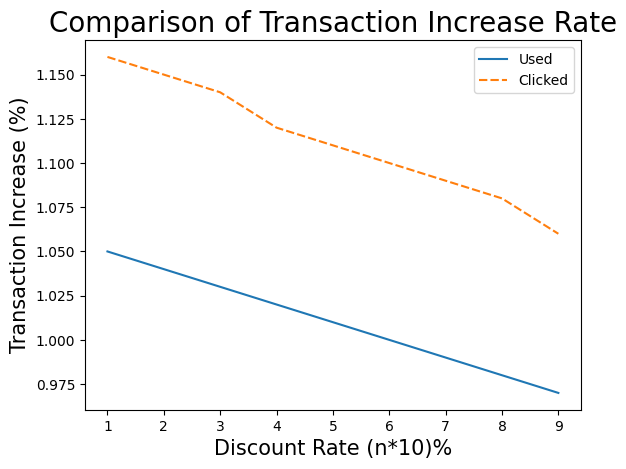

In [ ]:
data1 = round(pd.DataFrame(all_lr_scaled.predict(test_set(X_test_all_used, 1))).pct_change()*100, 2)
data2 = round(pd.DataFrame(all_lr_scaled.predict(test_set(X_test_all_clicked, 1))).pct_change()*100, 2)
df = pd.concat([data1, data2], axis=1).iloc[1:,:]
df.columns = ['Used','Clicked']
df
sns.lineplot(df)
plt.title('Comparison of Transaction Increase Rate', fontsize=20)
plt.xlabel('Discount Rate (n*10)%', fontsize=15)
plt.ylabel('Transaction Increase (%)', fontsize=15)
plt.xticks(range(1,10))
plt.show()

In [ ]:
df

,Used,Clicked
1,0.010504,0.011640
2,0.010395,0.011506
3,0.010288,0.011375
4,0.010183,0.011247
5,0.010080,0.011122
6,0.009980,0.010999
7,0.009881,0.010880
8,0.009784,0.010763
9,0.009690,0.010648


### 쿠폰 사용 그룹

#### 단항회귀 *

**전체 지역에서 쿠폰사용자만 추출하여 훈련~예측**



**모델 훈련**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    all_group_raw['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2236, 9), (560, 9), (2236,), (560,))

In [ ]:
# 정규화 처리
scaler = MinMaxScaler()
X = all_group_raw.drop('transaction', axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns = ['discnt price', 'price', 'California',	'Chicago',	'New Jersey',	'New York',	'Washington DC',	'Clicked',	'Used']
X_scaled

,discnt price,price,California,Chicago,New Jersey,New York,Washington DC,Clicked,Used
0,0.001255,0.000658,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.105504,0.067400,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.017644,0.015447,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.020548,0.011104,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.027910,0.015089,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2791,0.000281,0.000434,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2792,0.005460,0.009232,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2793,0.043905,0.029444,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2794,0.001071,0.001073,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# # 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled[X_scaled['Used'] == 1].iloc[:,:2],
#     all_group_raw[all_group_raw['Used']==1]['transaction'],
#     test_size=0.2,
#     random_state=121
# )
# X_train.shape, X_test.shape, y_train.shape, y_test.shape


In [ ]:
# 모델 생성과 훈련
all_group_lr = LinearRegression()
all_group_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
# 예측
data = X_test[X_test['Used'] == 1]
y_pred = all_group_lr.predict(data)
y_pred[:3]
y_test

1728     1
273     20
2173    13
2379     4
2596     4
        ..
941      1
197      9
586     14
1286     5
2242     3
Name: transaction, Length: 560, dtype: int64

In [ ]:
# 모델 정확도 확인
def model_accuracy(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  # mse & rmse & r^2 확인
  return print((f'MSE: {mse}'), (f'RMSE: {rmse}'), (f'R^2: {r2}'))
model_accuracy(y_test, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [560, 295]

**표준화**
- 표준화 결과가 너무 안좋아서 아래 정규화로 다시 진행

In [ ]:
# from sklearn.preprocessing import StandardScaler
# # 표준화 처리
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [ ]:
# 선형회귀 모델 적용 > 훈련
# all_group_lr = LinearRegression().fit(X_train_scaled, y_train)

In [ ]:
# 예측
# y_pred = all_group_lr.predict(X_test_scaled)
# y_pred[:3]

In [ ]:
# from sklearn.metrics import mean_squared_error, r2_score
# # 모델 정확도 확인
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)
# # mse & rmse & r^2 확인
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')
# print(f'R^2: {r2}')

**정규화**

In [ ]:
# 정규화 처리
scaler = MinMaxScaler()
X = all_group_raw.drop('transaction', axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns = ['discnt price', 'price', 'California',	'Chicago',	'New Jersey',	'New York',	'Washington DC',	'Clicked',	'Used']
X_scaled

,discnt price,price,California,Chicago,New Jersey,New York,Washington DC,Clicked,Used
0,0.001255,0.000658,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.105504,0.067400,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.017644,0.015447,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.020548,0.011104,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.027910,0.015089,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2791,0.000281,0.000434,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2792,0.005460,0.009232,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2793,0.043905,0.029444,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2794,0.001071,0.001073,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# # 교차검증
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(
#     LinearRegression(),
#     X_train,
#     y_train,
#     cv=5,
#     scoring='neg_mean_squared_error'
# )

# scores

In [ ]:
# mse_scores = -1 * scores
# rmse_scores = np.sqrt(mse_scores)

# # 평균 rmse
# rmse_mean = np.mean(rmse_scores)
# rmse_mean

In [ ]:
def X_mean(X_test):
  X_test_mean = X_test.mean()
  X_test_df = pd.DataFrame(X_test)
  data1 = X_test_df.iloc[:,0].mean()
  data2 = X_test_df.iloc[:, 1].mean()
  sample = pd.DataFrame([{'discnt price':data1, 'price':data2}])
  return sample
X_mean(X_test)

In [ ]:
# 테스트 세트 생성
def test_set(n):
  # 0에서 0.9까지 독립변수의 몇 퍼센트를 증가시킬지 설정 (10/20/30% 진행)
  array = np.arange(0, 1, 0.1*n)
  # 독립변수별 리스트 생성
  discnt_price_list = []
  price_list = []

  for i in array:
    discnt_price_list.append(X_mean(X_test)['discnt price']*(1+i))
    price_list.append(X_mean(X_test)['price'])

  test_dict = {
      'discnt price' : discnt_price_list,
      'price' : price_list
  }
  # price는 동일하고, discnt price는 10/20/30% 증가하는 DF
  test_set = pd.DataFrame(test_dict)
  return test_set

test_set(1)

all_group_lr.predict(test_set(1))

In [ ]:
# # 테스트 세트를 모델에 적용
# all_group_lr.predict(test_set)
# tolist() => 값과 컬럼을 리스트로 변환
sns.lineplot(x=np.arange(0, 10, 1), y=all_group_lr.predict(test_set(1)).tolist())
# 선형회귀선 시각화
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('discnt price * (1.n)')
plt.ylabel('prediction')
plt.show()

In [ ]:
# 지수표현식 없애기
pd.options.display.float_format = '{:.6f}'.format
# pct_change() => 행과 행의 차이를 현재값과의 백분율로 출력하는 메서드 => (다음행 - 현재행) / 현재행
pd.DataFrame(all_group_lr.predict(test_set(1))).pct_change().mean()

**[전지역 - 쿠폰사용]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 0.5% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 1.0% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 1.4% 늘어난다.

#### 다항회귀

In [ ]:
all_poly = PolynomialFeatures(degree=2, include_bias=False)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

In [ ]:
# X test 평균값
# X_mean(X_poly_test)

# 다차식이라서 새로운 함수 생성 필요 (5개)

In [ ]:
# 다차식이라서 새로운 test set 함수 생성 필요
# pd.DataFrame(all_poly_lr.predict(test_set(3))).pct_change()

#### RF*, GBM, XGB, LGBM

In [ ]:
def get_model_predict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)

  print('###',model.__class__.__name__,'###')
  model_accuracy(y_test, pred)

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

NameError: name 'RandomForestRegressor' is not defined

### 쿠폰 클릭 그룹

#### 단항회귀

**전체 지역에서 쿠폰클릭만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['Clicked'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['Clicked']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

In [ ]:
# X test 평균값
X_mean(X_test)

In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(3))).pct_change().mean()

**[전지역 - 쿠폰클릭]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.0% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 2.1% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 3.2% 늘어난다.

#### 다항회귀 *

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

In [ ]:
# X test 평균값
# X_mean(X_poly_test)

# 다차식이라서 새로운 함수 생성 필요 (5개)

In [ ]:
# 다차식이라서 새로운 test set 함수 생성 필요
# pd.DataFrame(all_poly_lr.predict(test_set(3))).pct_change()

#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

## B. 캘리포니아

### 쿠폰 사용 그룹

#### 단항회귀 *

**쿠폰사용만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['California']==1][X_scaled['Used'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['California']==1][all_group_raw['Used']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

In [ ]:
# X test 평균값
X_mean(X_test)

In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(3))).pct_change().mean()

NameError: name 'pd' is not defined

**[캘리포니아 - 쿠폰사용]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.7% 줄어든다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 3.3% 줄어든다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 5.0% 줄어든다.

#### 다항회귀

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### 쿠폰 클릭 그룹

#### 단항회귀 *

**쿠폰클릭만 추출하여 훈련~예측**

In [ ]:
X_scaled[X_scaled['California']==1][X_scaled['Clicked'] == 1].iloc[:,:2]
all_group_raw[all_group_raw['California']==1][all_group_raw['Clicked']==1]['transaction']

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['California']==1][X_scaled['Clicked'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['California']==1][all_group_raw['Clicked']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)
X_test

NameError: name 'all_group_lr' is not defined

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 70.61884215423427 RMSE: 8.403501779272393 R^2: 0.6960692195318519


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.053845,0.044868


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(1))).pct_change().mean()

0   0.018167
dtype: float64

**[캘리포니아 - 쿠폰클릭]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.8% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 3.7% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 5.5% 늘어난다.

#### 다항회귀

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((358, 5), (358, 2), (90, 5), (90, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([59.82237819, 12.03321042,  3.41250034])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 95.61741371012562 RMSE: 9.778415705528458 R^2: 0.5884798689874612


#### RF, GBM*, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 60.41877777777779 RMSE: 7.772951677308806 R^2: 0.7399684599072606
### GradientBoostingRegressor ###
MSE: 64.25986652182303 RMSE: 8.016225204036063 R^2: 0.7234371056084266
### XGBRegressor ###
MSE: 96.32052545598307 RMSE: 9.814302087055557 R^2: 0.585453802640918


## C. 시카고

### 쿠폰 사용 그룹

#### 단항회귀

**쿠폰사용만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['Chicago']==1][X_scaled['Used'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['Chicago']==1][all_group_raw['Used']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((345, 2), (87, 2), (345,), (87,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 40.58742484293325 RMSE: 6.370826072255721 R^2: 0.8940676247848596


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.030240,0.026734


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(1))).pct_change().mean()

0   -0.013482
dtype: float64

**[시카고 - 쿠폰사용]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.3% 줄어든다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 2.7% 줄어든다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 4.0% 줄어든다.

#### 다항회귀 *

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((345, 5), (345, 2), (87, 5), (87, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([ 2.87808332, 36.02566339,  1.98159079])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 24.15238568799817 RMSE: 4.91450767503706 R^2: 0.9369627515679335


#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 46.28241379310345 RMSE: 6.803117946434814 R^2: 0.8792038163848412
### GradientBoostingRegressor ###
MSE: 83.71520504747045 RMSE: 9.149601360030417 R^2: 0.7815049723745876
### XGBRegressor ###
MSE: 47.2659893941079 RMSE: 6.875026501338588 R^2: 0.8766367035408688


### 쿠폰 클릭 그룹

#### 단항회귀

**쿠폰클릭만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['Chicago']==1][X_scaled['Clicked'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['Chicago']==1][all_group_raw['Clicked']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((352, 2), (88, 2), (352,), (88,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 119.88131352996547 RMSE: 10.949032538538072 R^2: 0.8804350765026157


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.071497,0.056907


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(3))).pct_change().mean()

0   0.047412
dtype: float64

**[시카고 - 쿠폰클릭]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.6% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 3.2% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 4.7% 늘어난다.

#### 다항회귀 *

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((352, 5), (352, 2), (88, 5), (88, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([11.68207433,  3.93566915, 53.27522756])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 72.93876208588505 RMSE: 8.540419315577253 R^2: 0.927253737450809


#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 98.26397727272729 RMSE: 9.91281883586739 R^2: 0.9019953604176552
### GradientBoostingRegressor ###
MSE: 203.14087563639612 RMSE: 14.252749757025699 R^2: 0.7973952525254386
### XGBRegressor ###
MSE: 119.02139552943021 RMSE: 10.909692733043869 R^2: 0.8812927250128009


## D. 뉴저지

### 쿠폰 사용 그룹

#### 단항회귀 *

**쿠폰사용만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['New Jersey']==1][X_scaled['Used'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['New Jersey']==1][all_group_raw['Used']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((108, 2), (28, 2), (108,), (28,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 139.7184303585221 RMSE: 11.820255088555497 R^2: 0.5959795022883292


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.036737,0.030882


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(3))).pct_change().mean()

0   0.114881
dtype: float64

**[뉴저지 - 쿠폰사용]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 3.7% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 7.6% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 11.5% 늘어난다.

#### 다항회귀

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((108, 5), (108, 2), (28, 5), (28, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([10.27353862,  5.93387598,  2.01145336])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 157.4915954323673 RMSE: 12.549565547554517 R^2: 0.544585259019058


#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 240.07357142857137 RMSE: 15.494307710529418 R^2: 0.3057849020555248
### GradientBoostingRegressor ###
MSE: 281.0955377716239 RMSE: 16.765904024884072 R^2: 0.18716264716400632
### XGBRegressor ###
MSE: 264.67822529953116 RMSE: 16.26893436275195 R^2: 0.23463620336588042


### 쿠폰 클릭 그룹

#### 단항회귀

**쿠폰클릭만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['New Jersey']==1][X_scaled['Clicked'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['New Jersey']==1][all_group_raw['Clicked']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113, 2), (29, 2), (113,), (29,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 77.29317064376781 RMSE: 8.791653464722538 R^2: 0.2819825419585481


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.040048,0.034894


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(1))).pct_change().mean()

0   0.023145
dtype: float64

**[뉴저지 - 쿠폰클릭]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 2.3% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 4.7% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 7.1% 늘어난다.

#### 다항회귀 *

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((113, 5), (113, 2), (29, 5), (29, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([-8.41131662, 22.2603486 ,  4.14765313])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 62.33741183658922 RMSE: 7.895404475806747 R^2: 0.4209145566808252


#### RF, GBM, XGB*, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 50.165172413793094 RMSE: 7.0827376355328235 R^2: 0.5339889762735829
### GradientBoostingRegressor ###
MSE: 54.077972182196326 RMSE: 7.353772649613008 R^2: 0.4976408937698591
### XGBRegressor ###
MSE: 24.813097577457444 RMSE: 4.981274694037405 R^2: 0.769497911648459


## E. 뉴욕

### 쿠폰 사용 그룹

#### 단항회귀 *

**쿠폰사용만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['New York']==1][X_scaled['Used'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['New York']==1][all_group_raw['Used']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((243, 2), (61, 2), (243,), (61,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 26.33752079028347 RMSE: 5.132009430065719 R^2: 0.7219362087008296


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.034382,0.026794


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(1))).pct_change().mean()

0   0.001319
dtype: float64

**[뉴욕 - 쿠폰사용]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 0.1% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 0.3% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 0.4% 늘어난다.

#### 다항회귀

#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 29.99754098360655 RMSE: 5.477001093993551 R^2: 0.683294792931643
### GradientBoostingRegressor ###
MSE: 30.600798223682414 RMSE: 5.531798823500581 R^2: 0.6769257805769929
### XGBRegressor ###
MSE: 33.874842402018935 RMSE: 5.82020982456981 R^2: 0.6423593859509241


In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((243, 5), (243, 2), (61, 5), (61, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([ 5.1208743 , 26.58769114,  4.45131201])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 26.928141408777144 RMSE: 5.1892332197326745 R^2: 0.7157006100768922


### 쿠폰 클릭 그룹

#### 단항회귀

**쿠폰클릭만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['New York']==1][X_scaled['Clicked'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['New York']==1][all_group_raw['Clicked']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((254, 2), (64, 2), (254,), (64,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 33.92897326447877 RMSE: 5.824858218401437 R^2: 0.8081073447110834


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.038099,0.035057


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(3))).pct_change().mean()

0   0.029810
dtype: float64

**[뉴욕 - 쿠폰클릭]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.0% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 2.0% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 3.0% 늘어난다.

#### 다항회귀 *

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((254, 5), (254, 2), (64, 5), (64, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([5.91373388, 2.04183163, 1.34178355])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 25.43426339119121 RMSE: 5.043239374766104 R^2: 0.856151015846888


#### RF, GBM, XGB*, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 31.36125 RMSE: 5.6001116060307226 R^2: 0.8226296596490308
### GradientBoostingRegressor ###
MSE: 52.65467263384905 RMSE: 7.256353949046935 R^2: 0.7022000970581634
### XGBRegressor ###
MSE: 26.881978058052887 RMSE: 5.184783318331913 R^2: 0.847963152059815


## D. 워싱턴DC

### 쿠폰 사용 그룹

#### 단항회귀 *

**쿠폰사용만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['Washington DC']==1][X_scaled['Used'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['Washington DC']==1][all_group_raw['Used']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((57, 2), (15, 2), (57,), (15,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 19.820986730138063 RMSE: 4.452076676129699 R^2: 0.8439892949597333


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.030296,0.028802


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(1))).pct_change().mean()

0   0.009692
dtype: float64

**[워싱턴DC - 쿠폰사용]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 1.0% 늘어난다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 2.0% 늘어난다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 2.9% 늘어난다.

#### 다항회귀

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((57, 5), (57, 2), (15, 5), (15, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([16.43219286,  2.28270135, 14.37824993])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 32.65458051279874 RMSE: 5.7144186504664445 R^2: 0.7429762605688198


#### RF*, GBM, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 28.408666666666665 RMSE: 5.329978111274629 R^2: 0.7763957881480446
### GradientBoostingRegressor ###
MSE: 49.5756235138693 RMSE: 7.040995917756898 R^2: 0.6097909714328484
### XGBRegressor ###
MSE: 36.67105505629094 RMSE: 6.055663056700805 R^2: 0.7113626464820031


### 쿠폰 클릭 그룹

#### 단항회귀 *

**쿠폰클릭만 추출하여 훈련~예측**

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[X_scaled['Washington DC']==1][X_scaled['Clicked'] == 1].iloc[:,:2],
    all_group_raw[all_group_raw['Washington DC']==1][all_group_raw['Clicked']==1]['transaction'],
    test_size=0.2,
    random_state=121
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59, 2), (15, 2), (59,), (15,))

In [ ]:
all_group_lr.fit(X_train, y_train)
y_pred = all_group_lr.predict(X_test)

In [ ]:
# 모델 정확도 확인 (함수적용)
model_accuracy(y_test, y_pred)

MSE: 307.95094698457245 RMSE: 17.548531191657393 R^2: -3.0153548372466847


In [ ]:
# X test 평균값
X_mean(X_test)

,discnt price,price
0,0.050720,0.042598


In [ ]:
pd.DataFrame(all_group_lr.predict(test_set(3))).pct_change().mean()

0   -0.005551
dtype: float64

**[워싱턴DC - 쿠폰클릭]**
- 할인된 금액이 10% 증가할 때, 거래횟수는 평균 0.2% 줄어든다.
- 할인된 금액이 20% 증가할 때, 거래횟수는 평균 0.4% 줄어든다.
- 할인된 금액이 30% 증가할 때, 거래횟수는 평균 0.6% 줄어든다.

#### 다항회귀

In [ ]:
# 쿠폰 사용 그룹에서 만든 poly 모델 사용 (all_poly로 정의)
# 훈련 세트를 다차식으로
X_poly = all_poly.fit_transform(X_train)
# 테스트 세트를 다차식으로
X_poly_test = all_poly.transform(X_test)
# 데이터 확인
X_poly.shape, X_train.shape, X_poly_test.shape, X_test.shape

((59, 5), (59, 2), (15, 5), (15, 2))

In [ ]:
# 단항회귀 파트에서 생성해둔 LR 모델 사용해서 훈련 수행 (all_group_lr = LinearRegression())
all_poly_lr = all_group_lr.fit(X_poly, y_train)

In [ ]:
# 다차항이 추가된 feature를 test 값으로만 예측 (반드시 test값만)
y_test_pred = all_poly_lr.predict(X_poly_test)
y_test_pred[:3]

array([ 13.0645997 ,   5.96701146, 103.85122376])

In [ ]:
# 모델 정확도 확인 (함수사용)
model_accuracy(y_test, y_test_pred)

MSE: 493.0650700183763 RMSE: 22.205068565946295 R^2: -5.429047331602611


#### RF, GBM*, XGB, LGBM

In [ ]:
# 3가지 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=10)
gbm_reg = GradientBoostingRegressor(n_estimators=10)
xgb_reg = XGBRegressor(n_estimators=10)
# lgbm_reg = LGBMRegressor(n_estimators=10)

for model in [rf_reg, gbm_reg, xgb_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

### RandomForestRegressor ###
MSE: 84.32333333333332 RMSE: 9.18277372765622 R^2: -0.09948713490959649
### GradientBoostingRegressor ###
MSE: 47.94834772695231 RMSE: 6.924474545187693 R^2: 0.3748042281777776
### XGBRegressor ###
MSE: 70.87969546997765 RMSE: 8.419007986097748 R^2: 0.07580369258547925


# 코드보관

In [ ]:
# # 할인금액과 거래횟수의 상관관계
# sns.scatterplot(data=wdc_clicked_discnt_group, x='transaction', y='discnt price')

In [ ]:
# sns.lineplot(x=np.arange(0, 10, 3), y=wdc_clicked_discnt_lr.predict(test_set).tolist())
# # 선형회귀선 시각화
# plt.xticks(np.arange(0, 10, 1))
# plt.xlabel('discnt price * (1.n)')
# plt.ylabel('prediction')
# plt.show()

In [ ]:
# # 상관관계 확인하기 위한 과정

# # 쿠폰만 사용한 고객 DF에서 필요한 컬럼 추출한 후 이름 변경
# all_ck_corr = all_clicked.iloc[:, [5, 6, 7, 13, 15, 17, 18, 19, 21]]
# all_ck_corr.columns = ['Quantity', 'Avg.amt', 'Delivery', 'GST', 'Discnt','Price','VAT', 'Con.price', 'Monetary']
# # 제품 할인율에 따라 할인 적용된 금액으로 Monetary 다시 적용
# all_ck_corr['Monetary'] = all_ck_corr['Price'] * (1-(all_ck_corr['Discnt'] * 0.01))
# # 상관계수 반환
# all_ck_corr_matrix = np.abs(all_ck_corr.corr())

# # from re import search

# # 히트맵 시각화
# plt.figure(figsize=(10, 10))

# sns.heatmap(
#     data=all_ck_corr_matrix,
#     annot=True
# )

# plt.show()

In [ ]:
# # 쿠폰 클릭 & 쿠폰 클릭자가 할인 받았다고 가정한 경우 리텐션 시각화
# f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
# f.set_size_inches((15, 8))
# g1 = sns.heatmap(all_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
# g1.set_title('Clicked Coupon Retention Rate')
# g1.set_xlabel('Month Diff')
# g1.set_ylabel('First Purchase Month')
# g2 = sns.heatmap(all_retention_ck_discnt_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
# g2.set_title('Clicked Coupon Retention Rate (Discnt.ver)')
# g2.set_xlabel('Month Diff')
# g2.set_ylabel('First Purchase Month')
# plt.show()

In [ ]:
# ## 쿠폰 클릭 그룹이 실제 할인을 받았다고 가정하여 테이블 생성

# # 원본 복사
# all_clicked_discnt = all_clicked.copy()
# # 할인 적용된 금액으로 monetary 수정
# all_clicked_discnt['monetary'] = all_clicked_discnt['구매가격'] * (1-(all_clicked_discnt['할인율'] * 0.01))
# # 구매횟수 계산
# all_cohort_ck_discnt = all_clicked_discnt.groupby(['첫구매월', '월차이'])['고객ID'].nunique().reset_index()
# # 첫 구매 월은 행으로, 월 차이는 열로
# all_cohort_ck_discnt_pivot = all_cohort_ck_discnt.pivot(
#     index='첫구매월',
#     columns='월차이',
#     values='고객ID'
# )
# # 첫 구매 이후 월별 재구매율 (all_cohort_ck_discnt_size=첫구매월에 따른 고객ID)
# all_cohort_ck_discnt_size = all_cohort_ck_discnt_pivot.iloc[:,0]
# all_retention_ck_discnt_matrix = all_cohort_ck_discnt_pivot.divide(all_cohort_ck_discnt_size, axis=0)

In [ ]:
# # 위에서 한번 그렸었던, 쿠폰 사용자와 클릭자의 리텐션 그래프

# f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
# f.set_size_inches((15, 8))
# g1 = sns.heatmap(all_retention_matrix, annot=True, cmap="Blues", fmt='.0%', cbar=False, ax=ax1)
# g1.set_title('Used Coupon Retention Rate')
# g1.set_xlabel('Month Diff')
# g1.set_ylabel('First Purchase Month')
# g2 = sns.heatmap(all_retention_ck_matrix, annot=True, cmap="Blues", fmt='.0%', ax=ax2)
# g2.set_title('Clicked Coupon Retention Rate')
# g2.set_xlabel('Month Diff')
# g2.set_ylabel('First Purchase Month')
# plt.show()

In [ ]:
# all_retention_ck_list = round(all_retention_ck_matrix, 2).reset_index()
# # for mon_diff in all_retention_ck_list[]
# all_retention_ck_list

# all_clicked_discnt.groupby(['첫구매월', '월차이']).nunique()
# # retention = 첫구매월과 월차이로 그루핑한 값을 월차이가 0일 때 값으로 나눈것

# retention_list = []
# for month in range(1, 13):
#   fir_mon = all_clicked_discnt['첫구매월'] == month
#   for diff in range(0, 12):
#     mon_diff = all_clicked_discnt['월차이'] == (diff)
#     retention = all_clicked_discnt[fir_mon][mon_diff].nunique()['고객ID'] / all_clicked_discnt[fir_mon][all_clicked_discnt['월차이'] == 0].nunique()['고객ID']
#     retention_list.append(retention)

#     # all_clicked_discnt['리텐션'] = retention_list


# retention_list
